#Lab 5: Scale Invariant "blob" keypoint detector.

In this assignment you will code a scale invariant keypoint detector that can detect circular or blob like regions in an image. The goal of the assignment is to build a detector so that the dark circular regions in the centres of the sunflowers at different scales in the image can be found & marked.

![](https://github.com/tonyscan6003/etivities/blob/main/blob_flowers.JPG?raw=true)

As we have seen in the notes there are several possible ways to buid such a keypoint detector. For this assignment you will construct a Laplacian (of gaussian) scale space for the test image, and then seach this scale space for maxima that correspond to blobs in the image at different scales.

We will firstly load the required python packages and import the test image of sunflowers and display it.

In [1]:
import numpy as np
import urllib.request
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy import signal
from tqdm import tqdm
from scipy.signal import convolve2d


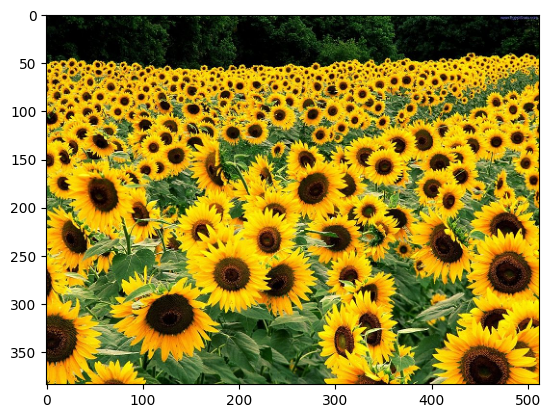

In [2]:
image_url_flowers = "https://github.com/tonyscan6003/etivities/blob/main/sunflowers_temp.jpg?raw=true"

# Function to read images from the Web.
def url_to_image(url):
	resp = urllib.request.urlopen(url)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB here..
	return temp_image

def read_image():
   # read Image
   sf =2
   image = url_to_image(image_url_flowers)
   #Scale Image by sf = 2
   x,y,z = np.shape(image)
   image_scale = cv2.resize(image, dsize=(int(y/sf), int(x/sf)), interpolation=cv2.INTER_CUBIC)
   #Convert to Greyscale
   gray = cv2.cvtColor(image_scale, cv2.COLOR_BGR2GRAY)
   return image_scale,gray

image_scale,gray = read_image()
plt.imshow(image_scale)

# Laplacian Scale Space:

Our goal in this section is to generate a laplacian scale space for the test image. We will perform this in three steps.

> **Step 1**: We will code a function that can generate kernel functions i.e. the 2nd order paratial derivatives of the gaussian function  $\frac{\partial^2{G(\mathbf{x},\sigma)}}{\partial{x}^2}$,$\frac{\partial^2{G(\mathbf{x},\sigma)}}{\partial{y}^2}$.

> **step 2**: We will code a function that convolves the image with gaussian derivative kernels to produce the Laplacian of Gaussians for any value of sigma.

> **Step 3**: We will use the convolution function we have just written in a for loop to create the scale space images and assign them to an array.

**Computation of kernels:**
As shown in the notes 2_2 (part B) (slide 4) the Laplacian scale space (for a given sigma) is formed from convolution of the partial derivatives of the gaussian kernel with the input image.
It is however computationally inefficient to convolve these large 2d kernels with the image. *Therefore the gaussian partial derivative kernels should be instead determined as seperable convoutions*. That is 2 sequential convolutions with 1d kernels.

Useful Information:
> The gaussian 1d forms including the 1st and 2nd order derivatives can be found [here](http://www.sci.utah.edu/~gerig/CS7960-S2010/handouts/04%20Gaussian%20derivatives.pdf)

> Seperable convolutions: Lecture 1_2 & [here](http://www.songho.ca/dsp/convolution/convolution2d_separable.html)

> [Scipy 2d Convolution command](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) (can be used with 1xn arrays as well as m x n):

> Numpy expand dims can be used to turn a list into an array

> Numpy transpose can be used to obtain transpose of an array



**Scale space range**: The code cell below defines a range of sigma values to generate your scale space over.

In [3]:
# Define Scale space
sigma_min = 1
sigma_max = 32
scale_fac = 1.05
# number of filters in scale space
num_scales = int((sigma_max-sigma_min)/scale_fac)
print("The number of scales is ",num_scales)
sigma_vals = np.linspace(sigma_min,sigma_max,num_scales) # Range of sigma values for scale space

The number of scales is  29


**Step 1:** In the code cell below you should complete the function that can output the 1d kernels that can be used to form the 2d Gaussians derivative kernels $\frac{\partial^2{G(\mathbf{x},\sigma)}}{\partial{x}^2}$,$\frac{\partial^2{G(\mathbf{x},\sigma)}}{\partial{y}^2}$ for a given sigma value. Hint: The same two 1d kernels are necessary to generate both 2D gaussian derivative kernels.

Note
> When generating 1d gaussian kernels it is necessary to ensure there are enough samples in the window for the gaussian to decay to zero (see lecture 1_2). With larger sigma values bigger kernels are needed. The code snippet below gives the range of samples needed for generating gaussian kernels of different sizes.
```
    k_size = int(6*sigma+1)
    rng = (k_size-1)//2
    x = np.arange(-rng,rng+1)
```



In [4]:
# Determines kernels for partial derivatives
def gauss_kernels(sigma):
    """
    sigma: Parameter controlling Gaussian blur
    K1: 1d kernel 1 x 2*rng+1 array
    K2: 1d kernel 1 x 2*rng+1 array
    """
    # Work out necessary kernel size and range to generate gaussian over.
    k_size = int(6*sigma+1)
    rng = (k_size-1)//2
    x = np.arange(-rng,rng+1)

    K1 =  (np.exp((-x**2)/(2*sigma**2)))/(np.sqrt(2*np.pi)*(sigma))
    K2 =  (np.exp((-x**2)/(2*sigma**2))*(x-sigma)*(x+sigma))/(np.sqrt(2*np.pi)*(sigma**5))


    return K1,K2

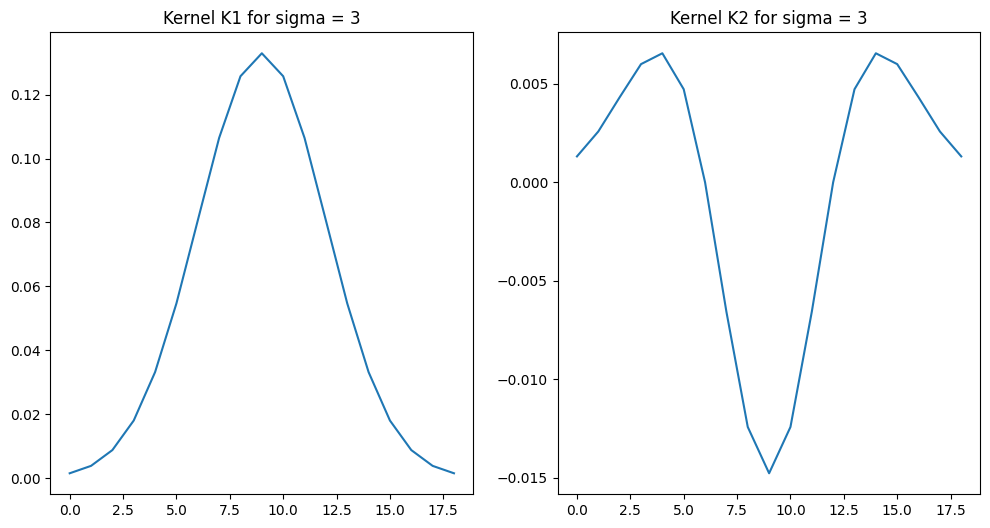

In [5]:
# Test the function with a sigma value
sigma_test = 3
K1_test, K2_test = gauss_kernels(sigma_test)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(K1_test)
plt.title('Kernel K1 for sigma = ' + str(sigma_test))

plt.subplot(1, 2, 2)
plt.plot(K2_test)
plt.title('Kernel K2 for sigma = ' + str(sigma_test))

plt.show()


Before moving to the next step, You can test if you can correctly generate the required 2D kernels from the 1D kernels by obtaining the outer product of the 1d kernels and plotting the result.

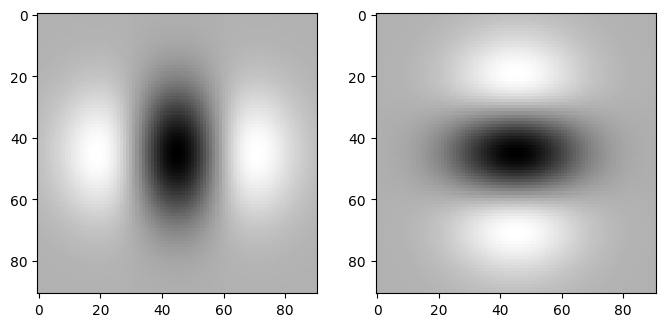

In [6]:
K1,K2 = gauss_kernels(15)

K_2d_x = np.outer(K1, K2)
K_2d_y = np.outer(K2, K1)

num_filt=2
fig = plt.figure(figsize=(8,8))
from mpl_toolkits import mplot3d
def plot_filter(A,i):
   ax = fig.add_subplot(num_filt,2, i)
   ax.imshow(A,'gray')
plot_filter(K_2d_x,1)
plot_filter(K_2d_y,2)

**Step 2:** In the code cell below you should complete the function that can output the normalised lapacian of a greyscale image for a given sigma value. You can re-use the function to generate the 1d kernels and then convolve the input image using seperable convolution as mentioned above.

In [7]:
#### Your Code Here ###
def laplacian(sigma,image):
    """
    sigma: Parameter controlling Gaussian blur
    image: input greyscale image n x m
    conv_laplacian: output image n x m to be returned,
                    result of convolution of image with laplacian of Gaussian
    """
    # 1 dimension gaussian kernels (Integration scale)
    K1,K2 = gauss_kernels(sigma)

    K_2d_x = np.outer(K1,K2)
    K_2d_y = np.outer(K2,K1)

    gaus_derv = np.array(( K_2d_x + K_2d_y ) * (sigma**2))

    conv_laplacian = signal.convolve2d(image, gaus_derv, boundary='fill', mode='same')

    return conv_laplacian






**Step 3:** Using the function that you have written, we will now iterate through the given sigma values and stack (using dstack) each scale space image to the array `laplace_scale_space`. This output array should be of dimension $n\times m \times k$ where $n$ and $m$ are the dimensions of the image and $k$ is the number of scales (`num_scales`).
We use greyscale image `gray` with your function along with each sigma value (not the original color image).

np.dstack: https://docs.scipy.org/doc/numpy/reference/generated/numpy.dstack.html





In [8]:
# Initialise sscale space as empty
laplace_scale_space = []
# Initialise pointer
ptr = 0

for k in tqdm(range(num_scales)): # For each sigma in scale space
   #Generate matrix components
   conv_laplacian = laplacian(sigma_vals[k],gray)
   # add to scale space
   laplace_scale_space = np.dstack((laplace_scale_space,conv_laplacian)) if ptr>0 else conv_laplacian
   #update pointer
   ptr += 1


100%|██████████| 29/29 [02:33<00:00,  5.28s/it]


In [9]:
print(np.shape(laplace_scale_space))

(384, 512, 29)


**View Lapacian Scale Space** If you have correctly generated the lapacian scale space, you can use the function in the cell below to visualise the scale space. The function will plot the laplacian and the square of the laplacian. (Note that your laplacian scale space will contain both positive and negative values, but the plot function will automatically offset and scale the values for dispay)

In [10]:
fig = plt.figure(figsize=(20,200))

def plot_filter(A,B,sigma,i):
   title_val = np.round(sigma,decimals=1)
   ax = fig.add_subplot(num_scales, 2, 2*(i+1)-1)
   ax.imshow(A,'gray')
   ax.title.set_text('LoG Image, Sigma Value = '+str(title_val))
   ax.axis('off')
   ax = fig.add_subplot(num_scales, 2, 2*(i+1))
   ax.imshow(B,'jet')
   ax.title.set_text('Sq Norm Lapacian')

ptr =0
# View Laplacian Scale space
for i in range(0,24,2):
    sigma = sigma_vals[i]
    laplace_conv = laplace_scale_space[:,:,i]
    # Obtain square norm
    sq_norm = laplace_conv**2
    # Call plotting
    plot_filter(laplace_conv,sq_norm,sigma,ptr)
    ptr+=1



Output hidden; open in https://colab.research.google.com to view.

# Maxima Detection.
If you have completed the notebook successfuly to this point, you should be able to see the maxima in the Normalised Laplacian image that you generated correspond to the stuctures in the original image. It should be evident that the reponse is maximised at particular scales (sigma values) and at particular locations in the image. (Images should be similar to slide 3 of lecture 2_2 part B)

The next step is to find the exact location of the local maxima in x,y space and scale. This may be achieved by iterating though all of the scale space images and determining if each point in scale space is a local maximum by comparing it's magnitude with each of it's 26 nearest neighbours (as shown in slide 6 of the lecture slides 2_2 part B). You should be able to convince yourself with a simple 1d example that this algorithm can find local maxima over all scales and positions.

In the code cell below complete the function `lap_max_det` . This function sets the conditions for detection of a maxima.  A threshold value `thresh` should be included to ensure that we include the strong maxima and avoid too many detections. This function should return a list `max_det` when a maxima is detected (it returns an empty list otherwise). The magnitude of the detected maximum in Laplacian scale space, the x,y position and the scale sigma are stored in the list.

The lap_max_det function is then used in the function `find_maxima` which contains a for loop (given) that iterates over all points in scale space and applies your condition to detect maxima.

Notes:

> The first and last images in the scale space are treated as auxillary images (i.e. These scale spaced are only used to assist in the determination of maxima of the 2nd and 2nd last layers.)

> The numpy [ravel](https://numpy.org/doc/stable/reference/generated/numpy.ravel.html) command may be useful







In [11]:
ws = 3  # Window size used for nearest neighbours
max_coords = np.empty((1,4)) # Array to store detected coordinates
eps = 1e-3 # Small epsilon value
n_max = 0 # Initialise variable counting no. maxima detected
thresh = 40 # Choose Threshold value



# Comparision with Nearest Neighbours for maxima detection
def lap_max_det(x,y,k,thresh):
    sigma = sigma_vals[k]    # Associated sigma current scale
    """
      x,y,k: are current point coordinates in scale space.
      thresh: is a threshold to ignore values.
      det_max: is a list containing, [mag, x, y, sigma ]
                  mag: magnitude of maxium in scale space
                  x,y spatial coordinates
                  value of sigma for current scale
      laplace_scale_space: previously created array in notebook containing scale spaces
    """
    # From Laplace Scale Space: Obtain magnitude of test point and
    # nearest neighbours for comparison.

    #### Your Code Here ###
    test_point_mag = laplace_scale_space[x,y,k]


    # Extract magnitudes of the neighboring 26 points
    x_min, x_max = max(0, x-1), min(laplace_scale_space.shape[0], x+2)
    y_min, y_max = max(0, y-1), min(laplace_scale_space.shape[1], y+2)
    k_min, k_max = k-1, k+2
    neighbour_points_mag = laplace_scale_space[x_min:x_max, y_min:y_max, k_min:k_max]
    neighbour_points_mag = neighbour_points_mag.ravel() # Convert the 3D neighborhood to 1D array

    # Remove the magnitude of the test point from neighbors
    test_index = np.where(neighbour_points_mag == test_point_mag)
    neighbour_points_mag = np.delete(neighbour_points_mag, test_index)

    # Condition for max detection
    if test_point_mag > thresh and np.all(test_point_mag > neighbour_points_mag):
        det_max = [test_point_mag, x, y, sigma]
    else:
        det_max =[]    # Output empty list if no max detected

    return det_max


x_max,y_max = np.shape(gray)
def find_maxima(max_coords,n_max):
   """
      max_coords: is an array size n_max x 4 where n_max are the number of maxima found
                  each row contains, [mag, x, y, sigma ]
                  mag: magnitude of detected maximum in scale space
                  x,y spatial coordinates
                  value of sigma for current scale.
   """
   # Iterate over scales
   for k in tqdm(range(1,num_scales-1)):
      # Iterate over spatial points
      for x in range(1,x_max-ws):
         for y in range(1,y_max-ws):

           det_max=lap_max_det(x,y,k,thresh)

           if det_max: # Add valid maxima to array
             max_coords = np.concatenate((max_coords,np.array([det_max]))) if n_max>0 else np.array([det_max])
             n_max+=1

   return max_coords,n_max


max_coords,n_max = find_maxima(max_coords,n_max)

100%|██████████| 27/27 [00:50<00:00,  1.87s/it]


**Display Maxima** The code below is provided to help you display you found keypoints over the original image. (some minor modification may be necessary depending on how you stored the keypoints from the last cell)

In [12]:
# Sort the maxima and draw largest 250 on the iamge
image,gray = read_image()


# sort in descending order (using magnitude)
index_coords=np.argsort(max_coords[:,0],axis=0)[::-1]

for i in index_coords[0:n_max]:
    [mag,x,y,sigma] = max_coords[i,:]
    br =int(math.ceil(1.414 * sigma))
    keypoints_img = cv2.circle(image, (int(y),int(x)), br, (255,0,0), 1)


# Plot keypoint image
plt.figure(figsize=(15,15))
plt.imshow(keypoints_img)


Output hidden; open in https://colab.research.google.com to view.

**Comments:**   
+ The sunflower disc at the far point is not identified with high accuracy.  
+ There were some areas, such as the upper right and lower left corners of the image, that were misdetected.  
+ In some areas, the detected circles appear to be slightly larger or smaller than the actual disc of the sunflower.